In [78]:

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [79]:
df = pd.read_parquet("data/dataset_procesada.parquet", engine="pyarrow")
df

,exportaciones,importaciones,precio_petroleo,igae,pib,consumo_final,inversion_total,tasa_inflacion
fecha,,,,,,,,
2008-10-01,-0.454482,-0.299724,-4.956194,0.037897,0.038064,0.581546,0.414413,-0.060587
2009-01-01,-1.812458,-0.796024,-1.256884,-0.886494,-0.886777,-0.798865,-0.811319,-1.995298
2009-04-01,0.356706,0.603206,1.470491,1.032076,1.032046,0.188213,0.485071,4.119722
2009-07-01,0.512052,0.556132,0.794157,-0.273556,-0.273605,-0.096622,-0.070220,-1.670576
2009-10-01,0.117188,0.069532,0.725736,0.123238,0.123502,0.652331,0.510964,-0.177565
...,...,...,...,...,...,...,...,...
2023-10-01,-0.949204,-0.144119,-0.283497,1.441632,1.441919,1.999727,0.736056,-0.302286
2024-01-01,-1.801562,-1.529920,-0.049535,-1.893434,-1.893470,-1.957061,-1.796246,0.082974
2024-04-01,1.673592,0.960185,0.375641,0.491718,0.491684,-0.176902,1.100735,0.528649


In [80]:
def seleccionar_orden_var(data, maxlags=4):
    modelo = VAR(data)
    resultados = modelo.select_order(maxlags=maxlags)
    
    # print("\n=== CRITERIOS DE SELECCIÓN DE ORDEN ===")
    # print(resultados.summary())
    
    # Obtener el orden recomendado por AIC
    orden_aic = resultados.aic
    print(f"\nOrden recomendado por AIC: {orden_aic}")
    
    return orden_aic

In [81]:
def entrenar_var(data, orden):
    modelo = VAR(data)
    modelo_fit = modelo.fit(orden)

    # Predicciones en el mismo rango de entrenamiento
    y_train_pred = modelo_fit.fittedvalues
    mae_train = {}
    rmse_train = {}

    for col in y_train_pred.columns:
        mae_train[col] = mean_absolute_error(data[col][ modelo_fit.k_ar:], y_train_pred[col])
        rmse_train[col] = np.sqrt(mean_squared_error(data[col][modelo_fit.k_ar:], y_train_pred[col]))

    print("MAE entrenamiento:", mae_train)
    print("RMSE entrenamiento:", rmse_train)
    
    return modelo_fit

In [82]:
def predecir_var(modelo_fit, steps, data_train):
    # Obtener los últimos valores para inicializar las predicciones
    lag_order = modelo_fit.k_ar
    forecast_input = data_train.values[-lag_order:]
    
    # Realizar predicción
    forecast = modelo_fit.forecast(forecast_input, steps)
    
    # Convertir a DataFrame con las mismas columnas
    forecast_df = pd.DataFrame(forecast, columns=data_train.columns)
    
    return forecast_df

In [83]:
def evaluar_modelo_var(y_real, y_pred):
    resultados = {}
    
    for columna in y_real.columns:
        mae = mean_absolute_error(y_real[columna], y_pred[columna])
        mse = mean_squared_error(y_real[columna], y_pred[columna])
        rmse = np.sqrt(mse)
        
        resultados[columna] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
    
    return resultados

In [84]:
def diagnosticos_var(modelo_fit):
    print("\n=== DIAGNÓSTICOS DEL MODELO VAR ===")
    
    # Test de autocorrelación serial (Breusch-Godfrey)
    try:
        test_serial = modelo_fit.test_serial_correlation(lags=10)
        print(f"Test de Autocorrelación Serial (p-value): {test_serial.pvalue:.6f}")
        
        if test_serial.pvalue > 0.05:
            print("No hay evidencia de autocorrelación serial")
        else:
            print("Existe autocorrelación serial en los residuos")
    except:
        print("No se pudo realizar el test de autocorrelación serial")
    
    # Test de normalidad de residuos
    try:
        test_normalidad = modelo_fit.test_normality()
        print(f"Test de Normalidad (p-value): {test_normalidad.pvalue:.6f}")
        
        if test_normalidad.pvalue > 0.05:
            print("Los residuos siguen distribución normal")
        else:
            print("Los residuos NO siguen distribución normal")
    except:
        print("No se pudo realizar el test de normalidad")
    
    print("EVALUACION GENERAL DEL MODELO VAR:")
    print(f"AIC: {modelo_fit.aic:.6f}")
    print(f"BIC: {modelo_fit.bic:.6f}")
    print(f"Log-Likelihood: {modelo_fit.llf:.6f}")
    
    return {
        'AIC': modelo_fit.aic,
        'BIC': modelo_fit.bic,
        'Log_Likelihood': modelo_fit.llf
    }

In [85]:
def test_causalidad_granger(modelo_fit, variable_objetivo='pib'):
    """
    Realiza test de causalidad de Granger
    """
    print(f"\n=== TEST DE CAUSALIDAD DE GRANGER - {variable_objetivo.upper()} ===")
    
    # Test de causalidad para cada variable hacia la variable objetivo
    for var in modelo_fit.names:
        if var != variable_objetivo:
            try:
                resultado = modelo_fit.test_causality(variable_objetivo, [var])
                print(f"{var} -> {variable_objetivo}: p-value = {resultado.pvalue:.6f}")
                
                if resultado.pvalue <= 0.05:
                    print(f"  {var} causa Granger a {variable_objetivo}")
                else:
                    print(f"  {var} NO causa Granger a {variable_objetivo}")
            except:
                print(f"  No se pudo realizar test para {var}")

In [86]:
def analisis_impulso_respuesta(modelo_fit, periodos=10):
    print(f"\n=== ANÁLISIS DE IMPULSO-RESPUESTA ({periodos} períodos) ===")
    
    # Calcular impulso-respuesta
    irf = modelo_fit.irf(periodos)
    
    # Mostrar resumen
    print("Funciones de impulso-respuesta calculadas")
    print(f"Variables: {modelo_fit.names}")
    
    return irf

In [87]:
def graficar_resultados_var(y_train, y_test, y_pred, fechas_train, fechas_test, variable_a_graficar, scaler_path='data/scaler_pib.joblib'):
    scaler = joblib.load(scaler_path)

    # Asegurarse de que los datos sean DataFrames para facilitar la selección por nombre
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test)
    if isinstance(y_pred, np.ndarray):
        pass

    # Desnormalizar todos los datos
    y_train_desnormalizado = scaler.inverse_transform(y_train)
    y_test_desnormalizado = scaler.inverse_transform(y_test)
    y_pred_desnormalizado = scaler.inverse_transform(y_pred) # Aplica el scaler a todas las columnas predichas

    # Convertir a DataFrame para facilitar la selección si tus datos originales tenían nombres de columna
    if isinstance(y_train, pd.DataFrame):
        y_train_desnormalizado = pd.DataFrame(y_train_desnormalizado, columns=y_train.columns)
        y_test_desnormalizado = pd.DataFrame(y_test_desnormalizado, columns=y_test.columns)
        y_pred_desnormalizado = pd.DataFrame(y_pred_desnormalizado, columns=y_test.columns)


    # Seleccionar la variable específica para graficar
    if isinstance(variable_a_graficar, str):
        try:
            pib_train = y_train_desnormalizado[variable_a_graficar]
            pib_test = y_test_desnormalizado[variable_a_graficar]
            pib_pred = y_pred_desnormalizado[variable_a_graficar]
        except KeyError:
            print(f"La variable '{variable_a_graficar}' no se encontró en los datos. Por favor, verifica el nombre o usa el índice numérico.")
            return
    elif isinstance(variable_a_graficar, int):
        pib_train = y_train_desnormalizado[:, variable_a_graficar]
        pib_test = y_test_desnormalizado[:, variable_a_graficar]
        pib_pred = y_pred_desnormalizado[:, variable_a_graficar]
    else:
        print("El argumento 'variable_a_graficar' debe ser un string (nombre de columna) o un entero (índice de columna).")
        return

    # Visualizar
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(fechas_test, pib_test, marker='.', label=f"Valor real {variable_a_graficar}")
    plt.plot(fechas_test, pib_pred, 'r', marker='.', label=f"Predicción {variable_a_graficar}")
    plt.plot(fechas_train, pib_train, 'g', marker='.', label=f"Histórico {variable_a_graficar}")
    plt.ylabel(f'{variable_a_graficar} de Bolivia')
    plt.xlabel('Fecha')
    plt.legend()
    plt.grid(True)
    plt.show()

In [88]:
def generarModelo(df):
    
    # 3. División train/test
    data_train = df[df.index < '2023-01-01']
    data_test = df[df.index >= '2023-01-01']
    
    print(f"\nDatos de entrenamiento: {data_train.shape}")
    print(f"Datos de prueba: {data_test.shape}")
    
    # 4. Seleccionar orden óptimo del VAR
    print("\n" + "="*50)
    print("SELECCIÓN DE ORDEN ÓPTIMO")
    print("="*50)
    
    orden_optimo = seleccionar_orden_var(data_train)
    
    # 5. Entrenar modelo VAR
    print("\n" + "="*50)
    print("ENTRENAMIENTO DEL MODELO VAR")
    print("="*50)
    
    modelo_var = entrenar_var(data_train, orden_optimo)
    print(f"Modelo VAR({orden_optimo}) entrenado exitosamente")
    
    # 6. Resumen del modelo
    print("\n=== RESUMEN DEL MODELO ===")
    print(modelo_var.summary())
    
    # 7. Realizar predicciones
    print("\n" + "="*50)
    print("REALIZANDO PREDICCIONES")
    print("="*50)
    
    predicciones = predecir_var(modelo_var, len(data_test), data_train)
    print(f"Predicciones realizadas: {predicciones.shape}")
    
    # 8. Evaluar modelo
    print("\n" + "="*50)
    print("EVALUACIÓN DEL MODELO")
    print("="*50)
    
    metricas = evaluar_modelo_var(data_test, predicciones)
    
    for variable, metricas_var in metricas.items():
        print(f"\n--- {variable.upper()} ---")
        for metrica, valor in metricas_var.items():
            print(f"{metrica}: {valor:.6f}")
    
    # 9. Diagnósticos del modelo
    diagnosticos = diagnosticos_var(modelo_var)
    
    # 10. Test de causalidad de Granger
    if 'pib' in df.columns:
        test_causalidad_granger(modelo_var, 'pib')
    
    # 12. Análisis de impulso-respuesta
    irf = analisis_impulso_respuesta(modelo_var)
    graficar_resultados_var(data_train, data_test, predicciones, data_train.index, data_test.index,'pib')
    
    return modelo_var, predicciones, metricas, irf

*Generacion de modelos*

Se quito MAPE porque no es una métrica adecuada para VAR

In [ ]:
df1 = df.drop('igae', axis=1)
generarModelo(df1)

In [ ]:
df2 = df.drop(['igae', 'importaciones', 'consumo_final'], axis=1)
generarModelo(df2)


Datos de entrenamiento: (57, 5)
Datos de prueba: (8, 5)

SELECCIÓN DE ORDEN ÓPTIMO

Orden recomendado por AIC: 4

ENTRENAMIENTO DEL MODELO VAR
MAE entrenamiento: {'importaciones': 0.24932077781176967, 'precio_petroleo': 0.4747239865707488, 'pib': 0.23934015901353387, 'consumo_final': 0.12380933162002325, 'tasa_inflacion': 0.20102898846894704}
RMSE entrenamiento: {'importaciones': 0.3284248142542772, 'precio_petroleo': 0.6142951252973775, 'pib': 0.4185299007054909, 'consumo_final': 0.21280392350831787, 'tasa_inflacion': 0.25622604950174555}
Modelo VAR(4) entrenado exitosamente

=== RESUMEN DEL MODELO ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Sep, 2025
Time:                     22:29:52
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -7.45034
Nobs:                     53.0000    HQIC:                  -9.85269
Log li

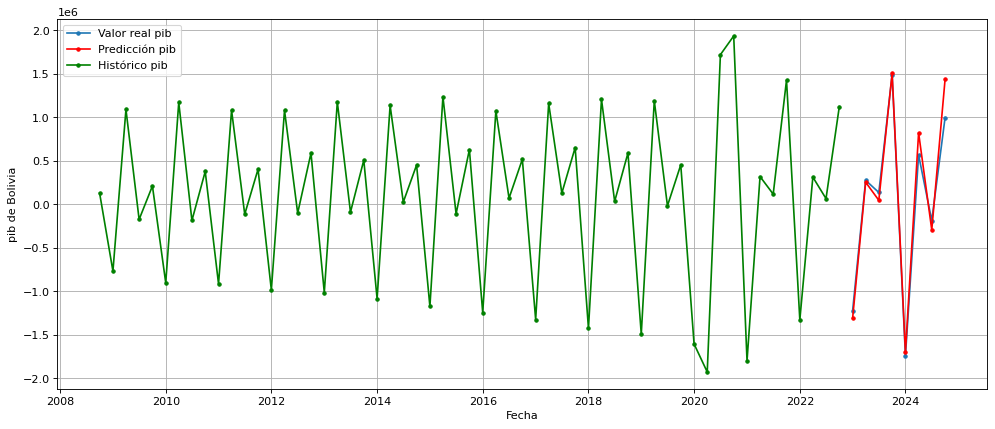

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x206dbca0a30>,
    importaciones  precio_petroleo       pib  consumo_final  tasa_inflacion
 0       0.050215         1.935109 -1.445759      -1.696446       -0.606617
 1       0.768987         0.731783  0.168579      -0.322837        1.344513
 2       0.777434        -1.679591 -0.046606       0.017153       -1.031542
 3      -0.693225        -0.668561  1.459787       2.061456        0.148782
 4      -1.574086         1.786383 -1.850169      -1.956767       -0.360625
 5       2.224095         0.986604  0.755452      -0.044181        0.932018
 6      -0.363815        -1.359055 -0.397489      -0.168572       -0.405411
 7       0.049711        -0.706509  1.388458       2.112844       -0.343360,
 {'importaciones': {'MAE': 0.5814982965628516,
   'MSE': 0.521038252342646,
   'RMSE': 0.7218297945794743},
  'precio_petroleo': {'MAE': 1.2411600665062374,
   'MSE': 2.2214038838144337,
   'RMSE': 1.49043748067956},
  'pib': {'MAE': 0.1369

In [90]:
df3 = df.drop(['igae', 'exportaciones', 'inversion_total'], axis=1)
generarModelo(df3)

In [ ]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
generarModelo(df4)

In [ ]:
df5 = df.drop(['igae', 'exportaciones','consumo_final', 'inversion_total'], axis=1)
generarModelo(df5)